# News Engagement Prediction

Create a system that predicts the engagement of a given news article based on its content (title and/or article text):
* Data from https://webhose.io/free-datasets/popular-news-articles/
* word2vec-CNN-BiLSTM model
* Trained on Triton supercomputer GPUs
* Created in Jupyter Notebook using Pytorch
* Deliverable as requestable API on AWS
* Possibly create a dashboard for user to test and rank different word choices

## Preprocess

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import json
import pickle
import pytz
import requests
import warnings
# warnings.filterwarnings('ignore')
from datetime import datetime
from termcolor import colored

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from flask import Flask

import preprocess as pp
import graph as gp
import hparams as hp
import model as ml
import train as tr
import postprocess as pop
import evaluate as ev
import api as api

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# ml_choice: cnn-bilstm
ml_choice = 'cnn-bilstm'

# dataset: webhose-popular
dataset = 'webhose-popular'

update_dict = {}
update_dict['ml_choice'] = ml_choice
update_dict['dataset'] = dataset

In [8]:
data_all = pp.read_data(dataset)
data_all = pp.remove_keys(data_all)
data_all = pp.cal_all_engagements(data_all)

titles = pp.get_titles(data_all)
data_all_ordered = pp.order_keys(data_all)

In [9]:
pp.pprint(data_all_ordered[0])

{
    "title": "Here are The Funniest Reaction Memes To Beyonce's Pregnancy | Angie Martinez | Power 105.1 FM",
    "sanitized_title": "here are the funniest reaction memes to beyonces pregnancy",
    "text": "Here are The Funniest Reaction Memes To Beyonce's Pregnancy posted by Gabriel Pabon - \nThe internet wastes no time when reacting to big news especially when it comes to Beyonce . \nCheck out the funniest memes from today's announcement below. A photo posted by HONEY GERMAN (@honeygerman) on Feb 1, 2017 at 1:03pm PST A photo posted by HONEY GERMAN (@honeygerman) on Feb 1, 2017 at 12:57pm PST A photo posted by HONEY GERMAN (@honeygerman) on Feb 1, 2017 at 11:40am PST A photo posted by SSquared Podcast/Radio Show (@teamssquared) on Feb 1, 2017 at 2:07pm PST A photo posted by D-Roc \u264f\ufe0f (@inked_scorpio) on Feb 1, 2017 at 2:07pm PST A photo posted by At Random With Yeasha (@random_yeasha) on Feb 1, 2017 at 2:05pm PST Left or Right? \uf62d #beyonce pic.twitter.com/PPhB9QmUAy v

In [23]:
# currently using only titles to save on training time
all_text = pp.get_all_text(titles)
words = pp.get_words(all_text)

# score: 'original', 'log_weigh', 'log_no_weigh', 'no_log_weigh', 'no_log_no_weigh'
scores = pp.get_scores(data_all_ordered)
mean, std = pp.get_mean_std(scores)
update_dict['mean'] = mean
update_dict['std'] = std
scores_scaled = pp.scale_data(scores, mean, std)

In [22]:
tokens = pp.tokenize_words(words)
update_dict['embed_in'] = len(tokens)+1
title_tokens = pp.tokenize_titles(titles, tokens)
title_lengths = pp.get_title_lengths(title_tokens)
title_tokens, titles, scores_scaled = pp.remove_shorts(title_tokens, titles, scores_scaled, min_len=3)
padded_titles = pp.pad_titles(title_tokens)

poop head alsdkjfas asdfasdf aaaaa aaa


In [8]:
train_x, val_x, test_x = pp.split_data(padded_titles)
train_y, val_y, test_y = pp.split_data(scores_scaled)

print("Train Size: {}".format(train_x.shape),
      "\nValidation Size: {}".format(val_x.shape),
      "\nTest Size: {}".format(test_x.shape))

Train Size: (156, 25) 
Validation Size: (20, 25) 
Test Size: (20, 25)


In [9]:
train_data = pp.create_tensor_dataset(train_x, train_y)
val_data = pp.create_tensor_dataset(val_x, val_y)
test_data = pp.create_tensor_dataset(test_x, test_y)

train_loader = pp.create_loader(train_data)
val_loader = pp.create_loader(val_data)
test_loader = pp.create_loader(test_data, shuffle=False)

## Model

In [10]:
architecture = ml.MODELS[ml_choice]
hps = hp.setup_hparams(architecture, update_dict)
hps = pp.update_hps(hps)
model = ml.CNN_BiLSTM(hps)
print(model)

CNN_BiLSTM(
  (embed): Embedding(1288, 200, padding_idx=0)
  (bilstm): LSTM(200, 100, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=500, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Train

In [11]:
folder = tr.create_folder()
update_dict['folder_s'] = folder
seed = tr.set_seed()
hps, model, ml_file, losses = tr.run(train_loader, val_loader, update_dict, epochs=100)

Running...
Epoch: 1/100
Train Loss: 1.60991
Val Loss: 0.35508
Min Loss: 0.35508
Min Loss: 0.29991
Min Loss: 0.26939
Epoch: 10/100
Train Loss: 0.02326
Val Loss: 0.29671
Epoch: 20/100
Train Loss: 0.01499
Val Loss: 0.28490
No progress detected in 20 epochs...
Saving model...

In [12]:
tr.save(folder, 'hps', hps)    
tr.save(folder, 'ml_file', ml_file)
tr.save(folder, 'tokens', tokens)
tr.save(folder, 'losses', losses)

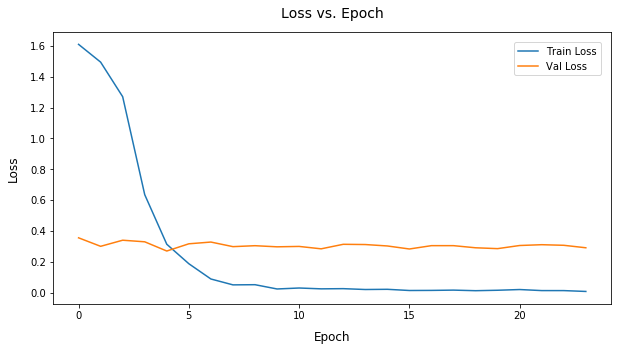

In [13]:
gp.graph_losses(losses)

## Postprocess

In [14]:
inputses, labelses, outputs = pop.test(hps, model, test_loader)
outputs_scaled = pop.rescale(outputs, hps)
labelses_scaled = pop.rescale(labelses, hps)
detokens = pop.get_detokens(tokens)
inputses = pop.detokenize(inputses, detokens)
results = pop.join_results(inputses, outputs_scaled)

## Evaluate

In [15]:
mse = ev.mse(outputs_scaled, labelses_scaled)
# mse = ev.mse(outputs, labelses)
print(mse)

0.9984044315285295


## API

In [2]:
# folder = folder
# hps, model, tokens = api.load_all(folder)
# api.set_all(hps, model, tokens)

In [3]:
local_url = 'http://localhost:5000/predict'
heroku_url = 'http://news-engagement-prediction.herokuapp.com/predict'
test_title = 'Beyonce hostage situation'
data = json.dumps({
    'title': test_title
})

In [4]:
prediction = api.get_prediction(test_title)

In [5]:
response = requests.post(heroku_url, data)
print(response)
# print(response.json())

<Response [500]>
